# Credit Card Fraud

This dataset consists of 339,607 credit card transactions in the United States. It includes information about each transaction including customer details, the merchant and category of purchase, and whether or not the transaction was a fraud.

In [56]:
#libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from datetime import datetime
import locale
import warnings
warnings.filterwarnings("ignore", category=UserWarning, 
                        message="Boolean Series key will be reindexed to match DataFrame index")
from statsmodels.stats.proportion import proportions_ztest

#import original data 
ori_data = pd.read_csv('documents/python/credit_card_fraud.csv') 

#know your data
print(ori_data.head())

#Drop lat and long columns
DE_data = ori_data.drop(['lat', 'long', 'merch_lat', 'merch_long'], 
                        axis = 1)  #ETL-1

#confirm the deletion
print(DE_data.head())

#how many NAs are in the dataset

Tot_NAs = DE_data.isna().sum().reset_index()  #sum NA observations per column
NAtable = tabulate(Tot_NAs, headers = ['Column Name',
                                       'NA observations'], 
                   showindex = False, 
                   tablefmt = 'fancy_grid') #formating a table

print(NAtable)


#As there are no NAs, let's further dive into ETL-2
#Let's create separate columns for Date, Month, Year, and Time

DE_data['Date'] = pd.to_datetime(DE_data['trans_date_trans_time']).dt.date #date column
DE_data['Month'] = pd.to_datetime(DE_data['trans_date_trans_time']).dt.month #month column
DE_data['Year'] = pd.to_datetime(DE_data['trans_date_trans_time']).dt.year #year column
DE_data['Time'] = pd.to_datetime(DE_data['trans_date_trans_time']).dt.hour #time column
DE_data['dob'] = pd.to_datetime(DE_data['dob']) #converting DOB to Date Time format
DE_data['Day_Transaction'] = pd.to_datetime(DE_data['trans_date_trans_time']).dt.day_name() #Day name

DE_data.describe()


  trans_date_trans_time                   merchant       category     amt  \
0   2019-01-01 00:00:44  Heller, Gutmann and Zieme    grocery_pos  107.23   
1   2019-01-01 00:00:51             Lind-Buckridge  entertainment  220.11   
2   2019-01-01 00:07:27                  Kiehn Inc    grocery_pos   96.29   
3   2019-01-01 00:09:03                Beier-Hyatt   shopping_pos    7.77   
4   2019-01-01 00:21:32                 Bruen-Yost       misc_pos    6.85   

                       city state      lat      long  city_pop  \
0                    Orient    WA  48.8878 -118.2105       149   
1                Malad City    ID  42.1808 -112.2620      4154   
2                   Grenada    CA  41.6125 -122.5258       589   
3  High Rolls Mountain Park    NM  32.9396 -105.8189       899   
4                   Freedom    WY  43.0172 -111.0292       471   

                                 job         dob  \
0  Special educational needs teacher  1978-06-21   
1        Nature conservation officer

,amt,city_pop,is_fraud,Month,Year,Time
count,339607.000000,3.396070e+05,339607.000000,339607.000000,339607.000000,339607.000000
mean,70.577984,1.071409e+05,0.005247,7.157897,2019.499307,12.814480
std,161.675242,2.930299e+05,0.072248,3.423984,0.500000,6.812057
min,1.000000,4.600000e+01,0.000000,1.000000,2019.000000,0.000000
25%,9.600000,4.710000e+02,0.000000,4.000000,2019.000000,7.000000
50%,46.460000,1.645000e+03,0.000000,7.000000,2019.000000,14.000000
75%,83.350000,3.543900e+04,0.000000,10.000000,2020.000000,19.000000
max,28948.900000,2.383912e+06,1.000000,12.000000,2020.000000,23.000000


In [57]:
# Count the number of fraud transactions in the dataset

Total_fraud_trscts = len(DE_data[DE_data['is_fraud'] == 1])
print(tabulate([[Total_fraud_trscts]], 
               headers=['Total Fraud Transactions'], 
               showindex=False, tablefmt='fancy_grid'))

#Percentage of Fraud transactions 

Fraud_Perc = (Total_fraud_trscts / len(DE_data))

print(f'The total transactions are {len(DE_data)} and fraud transactions {Total_fraud_trscts}, which is {round(Fraud_Perc,6)}% of the total transactions')

╒════════════════════════════╕
│   Total Fraud Transactions │
╞════════════════════════════╡
│                       1782 │
╘════════════════════════════╛
The total transactions are 339607 and fraud transactions 1782, which is 0.005247% of the total transactions


Total transactions amount is $23968777.40
The sum of fraud transactions is $923192.65


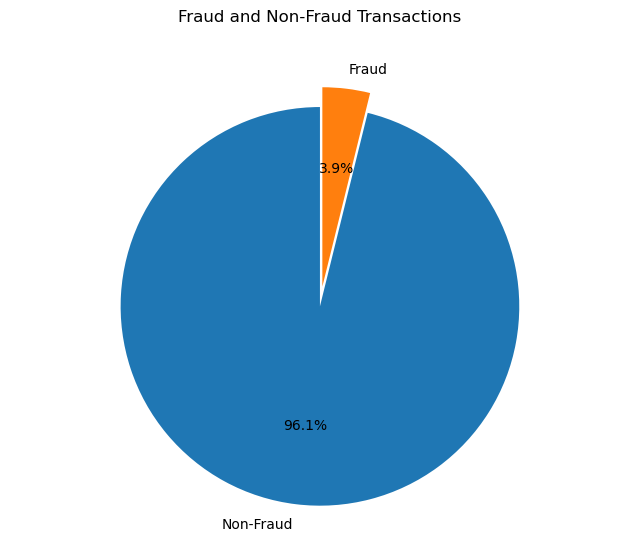

In [58]:

# Set the locale to the default system locale
locale.setlocale(locale.LC_ALL, '')

# Calculate the total transactions amount
Total_trnscts_amt = DE_data['amt'].sum()
print(f'Total transactions amount is {locale.currency(Total_trnscts_amt)}')

# Calculate the sum of fraud transactions amount
Total_amt_fraud_trnscts = DE_data[DE_data['is_fraud'] == 1]['amt'].sum()
print(f'The sum of fraud transactions is {locale.currency(Total_amt_fraud_trnscts)}')

# Pie chart
labels = ['Non-Fraud', 'Fraud']
sizes = [Total_trnscts_amt - Total_amt_fraud_trnscts, 
         Total_amt_fraud_trnscts]
colors = ['#1f77b4', '#ff7f0e']
explode = (0, 0.1)
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, 
        autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Fraud and Non-Fraud Transactions')

# Add one line distance between title and labels
plt.gca().set_title('Fraud and Non-Fraud Transactions\n', pad=20)

plt.show()

In [59]:
#What are the top 10 max amount transactions

Max_fraud_amt = DE_data[DE_data['is_fraud']==1]['amt'].groupby(by=DE_data['category']).max().sort_values(ascending=False).head(10)

print(tabulate(Max_fraud_amt.reset_index(), headers=['Category',
                                                     'Amount in $'], 
               showindex=False, tablefmt='fancy_grid'))

╒════════════════╤═══════════════╕
│ Category       │   Amount in $ │
╞════════════════╪═══════════════╡
│ shopping_pos   │       1371.81 │
├────────────────┼───────────────┤
│ shopping_net   │       1281.51 │
├────────────────┼───────────────┤
│ misc_net       │       1054.8  │
├────────────────┼───────────────┤
│ misc_pos       │        971.57 │
├────────────────┼───────────────┤
│ entertainment  │        695.53 │
├────────────────┼───────────────┤
│ home           │        443.25 │
├────────────────┼───────────────┤
│ grocery_pos    │        397.97 │
├────────────────┼───────────────┤
│ food_dining    │        140.03 │
├────────────────┼───────────────┤
│ personal_care  │         53.26 │
├────────────────┼───────────────┤
│ health_fitness │         26.13 │
╘════════════════╧═══════════════╛


       is_fraud
state          
AK           50
AZ           64
CA          402
CO          115
HI           16
ID           33
MO          262
NE          216
NM          121
OR          197
UT           61
WA          126
WY          119


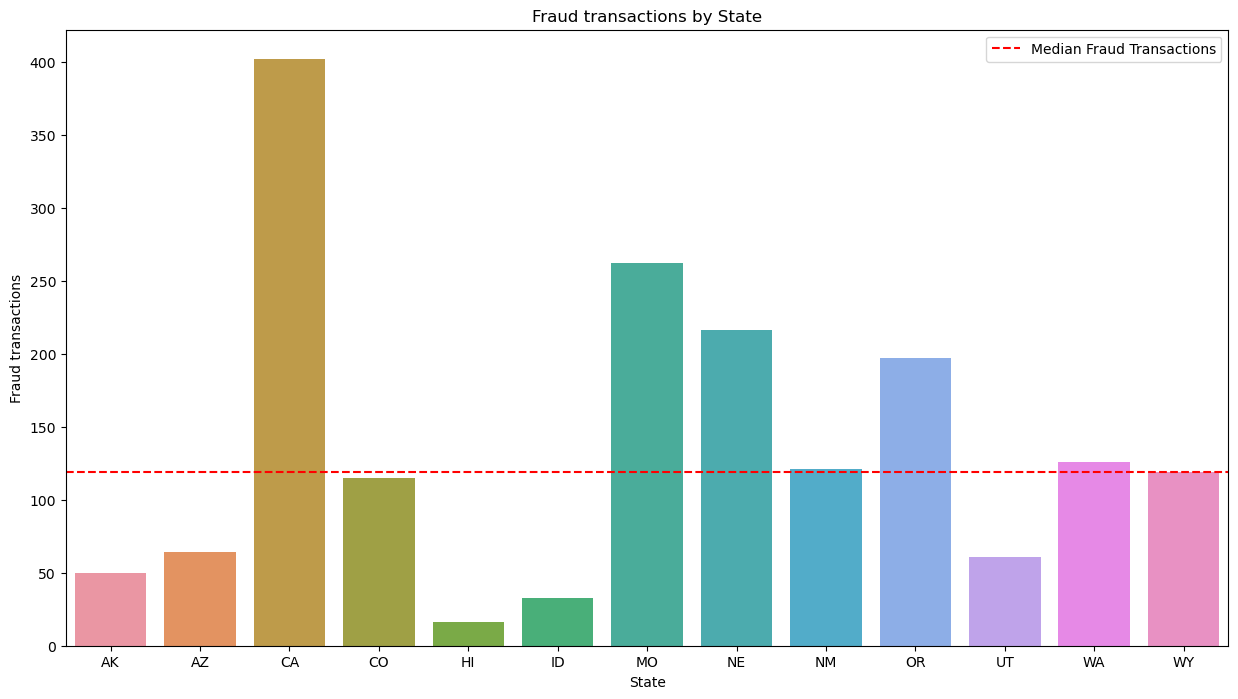

In [60]:
#Which state has the most fraud transactions

State_fraud_trnscts = DE_data[DE_data['is_fraud']==1].groupby('state').count()
print(State_fraud_trnscts.pivot_table(values='is_fraud',index='state'))

#barchart 
_ = plt.figure(figsize=(15,8))
_ = sns.barplot(data=State_fraud_trnscts.reset_index(), x='state', 
                y='is_fraud')
_ = plt.xlabel('State')
_ = plt.ylabel('Fraud transactions')
_ = plt.title('Fraud transactions by State')
_ = plt.axhline(State_fraud_trnscts['is_fraud'].median(), color='red', 
                linestyle='--', label='Median Fraud Transactions')
_ = plt.legend()

plt.show()

      is_fraud
Time          
0          168
1          168
2          140
3          143
4            7
5           10
6            7
7            9
8           12
9           11
10          10
11           6
12          17
13          14
14          15
15          22
16          23
17          20
18          18
19          11
20          23
21          17
22         452
23         459


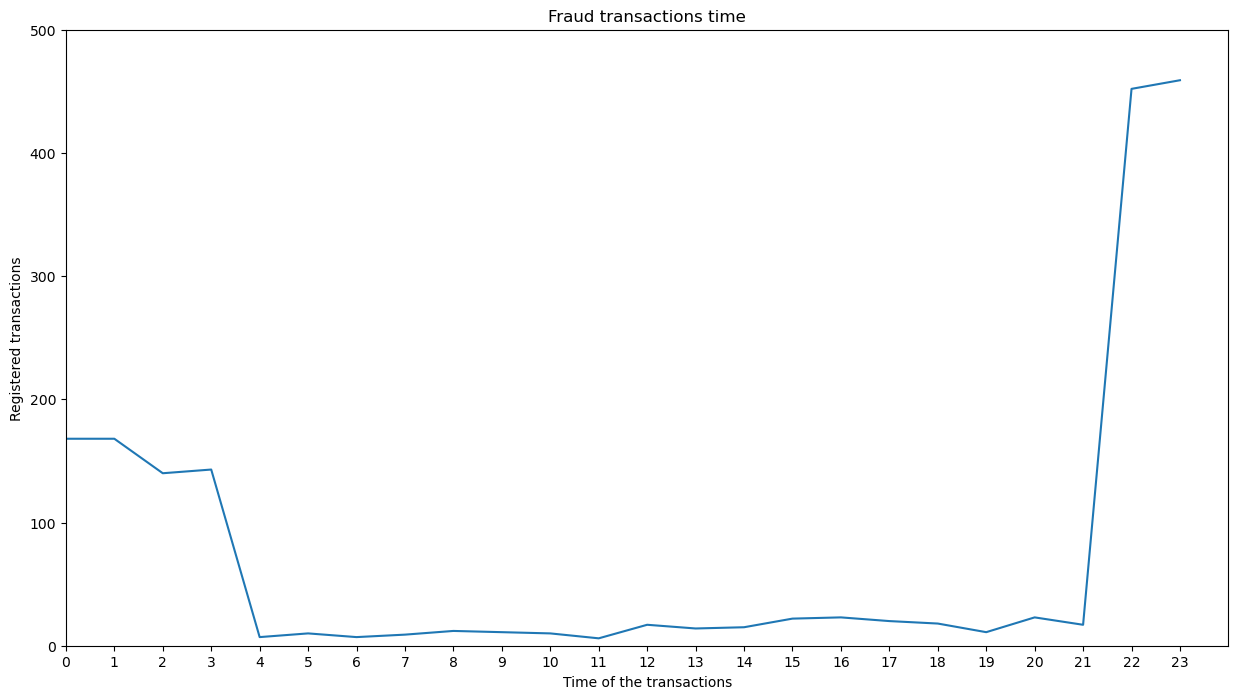

In [61]:
#what is the fraud transactions peak time

fraud_trnscts = DE_data[DE_data['is_fraud']==1].groupby('Time').count()

print(fraud_trnscts.pivot_table(values='is_fraud', index='Time'))


_ = plt.figure(figsize=(15,8))
_ = sns.lineplot(data=fraud_trnscts, x='Time', y='is_fraud')
_ = plt.xlabel('Time of the transactions')
_ = plt.ylabel('Registered transactions')
_ = plt.title('Fraud transactions time')
_ = plt.xlim(0, 24, 1)
_ = plt.xticks(range(0, 24, 1))
_ = plt.ylim(0, 500, 100)

plt.show()

╒════════════╕
│   User Age │
╞════════════╡
│         45 │
├────────────┤
│         61 │
├────────────┤
│         78 │
├────────────┤
│         56 │
├────────────┤
│         56 │
╘════════════╛
Total Fraud transactions: 1782
          is_fraud
User Age          
23              10
24              45
25              13
26              23
27              31
28              27
30              18
31              37
32              18
33              14


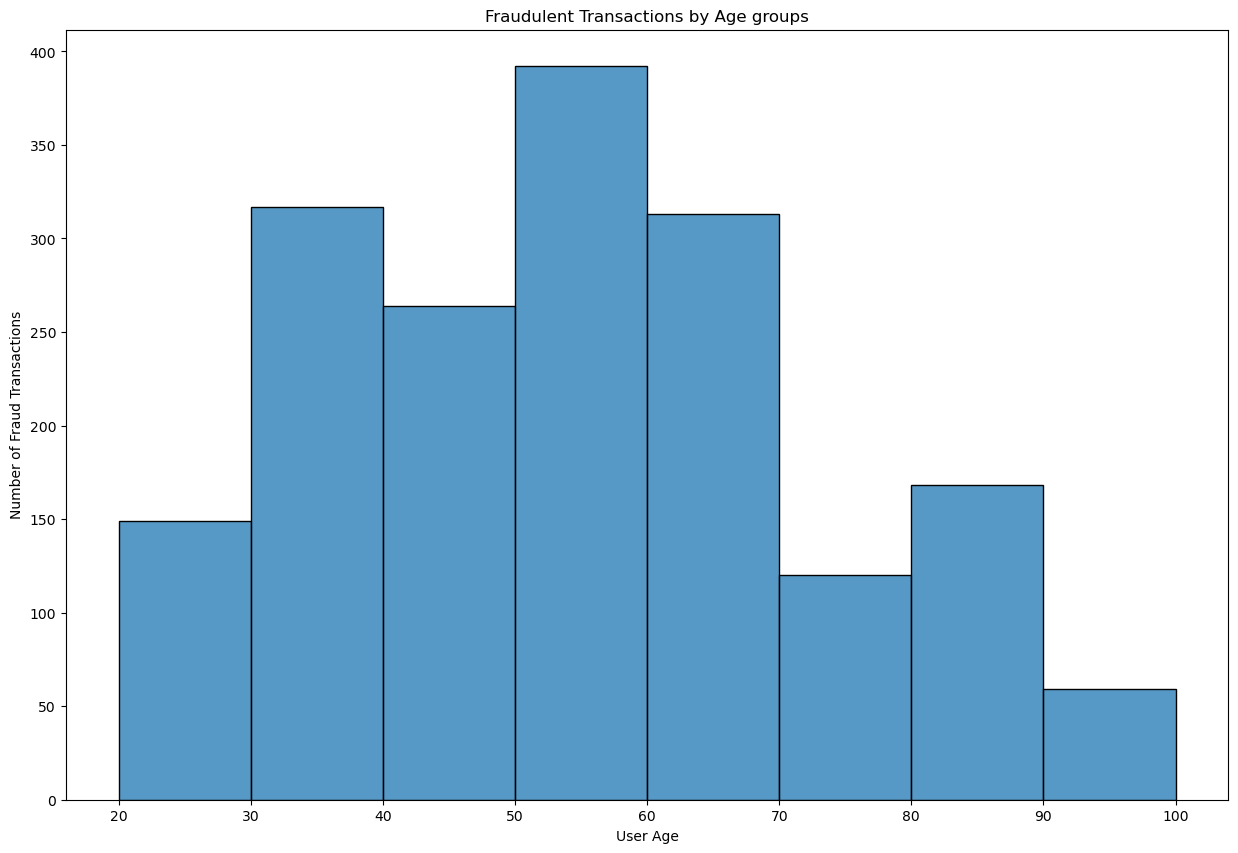

In [62]:
#What age group is most likely to be victim of fraud

DE_data['User Age'] = (datetime.today().year - DE_data['dob'].dt.year)

print(tabulate([[age] for age in DE_data['User Age'].head()], 
               headers=['User Age'], showindex=False,
              tablefmt='fancy_grid')) 

##Fraud transactions group by Age
Frud_trac_age = DE_data[DE_data['is_fraud'] == 1].groupby('User Age').count()
print(f'Total Fraud transactions: {Frud_trac_age["is_fraud"].sum()}') #comforming total fraud transactions after 
                                                                        #group by User Age

#Fraude transactions by user age
print(Frud_trac_age.pivot_table(values='is_fraud', index = 'User Age').head(10)) 


#Histogram of Fraud transactions by User Age
bins = [20, 30, 40, 50, 60, 70, 80, 90, 100]  

_ = plt.figure(figsize=(15,10))
_ = sns.histplot(data=Frud_trac_age, x='User Age', 
                 weights='is_fraud', bins=bins) 
_ = plt.xlabel("User Age")
_ = plt.ylabel('Number of Fraud Transactions')
_ = plt.title('Fraudulent Transactions by Age groups')

plt.show()

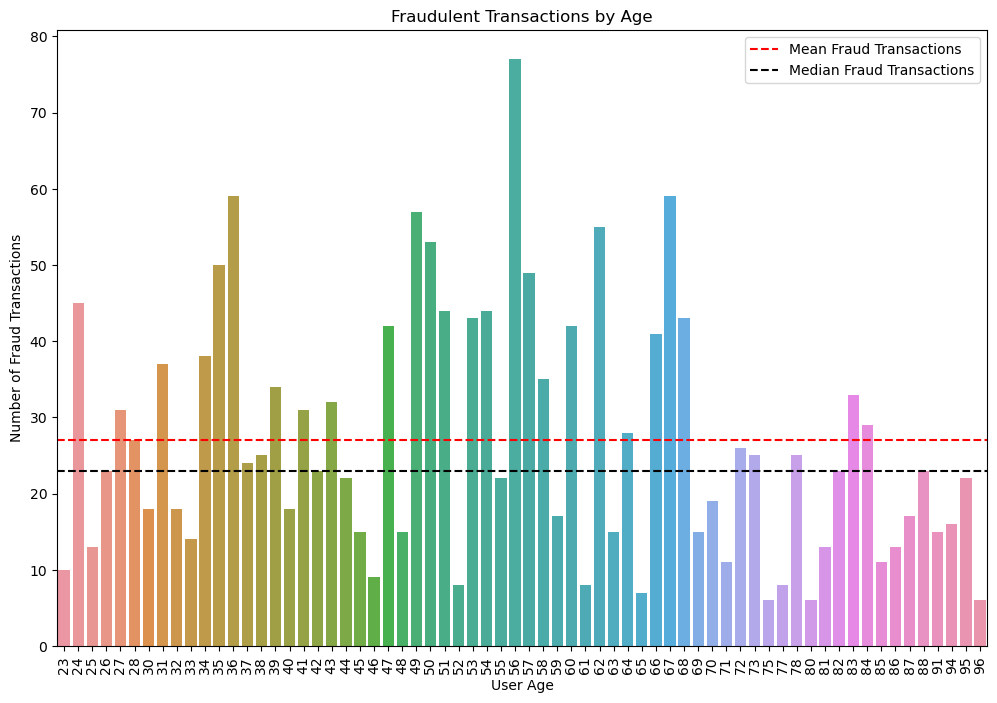

In [63]:
#bar chart with mean age and mean fraud transaction lines
_ = plt.figure(figsize=(12, 8))
_ = sns.barplot(data=Frud_trac_age.reset_index(), x='User Age', 
                y='is_fraud')
_ = plt.xlabel("User Age")
_ = plt.ylabel('Number of Fraud Transactions')
_ = plt.title('Fraudulent Transactions by Age')
_ = plt.axhline(Frud_trac_age['is_fraud'].mean(), color='red', 
                linestyle='--', 
                label='Mean Fraud Transactions')
_ = plt.axhline(Frud_trac_age['is_fraud'].median(), color='black', 
                linestyle='--', 
                label='Median Fraud Transactions')
_ = plt.legend()
plt.xticks(rotation=90)
plt.show()


                is_fraud
category                
entertainment         55
food_dining           38
gas_transport        153
grocery_net           27
grocery_pos          433
health_fitness        36
home                  50
kids_pets             55
misc_net             217
misc_pos              62
personal_care         55
shopping_net         381
shopping_pos         187
travel                33


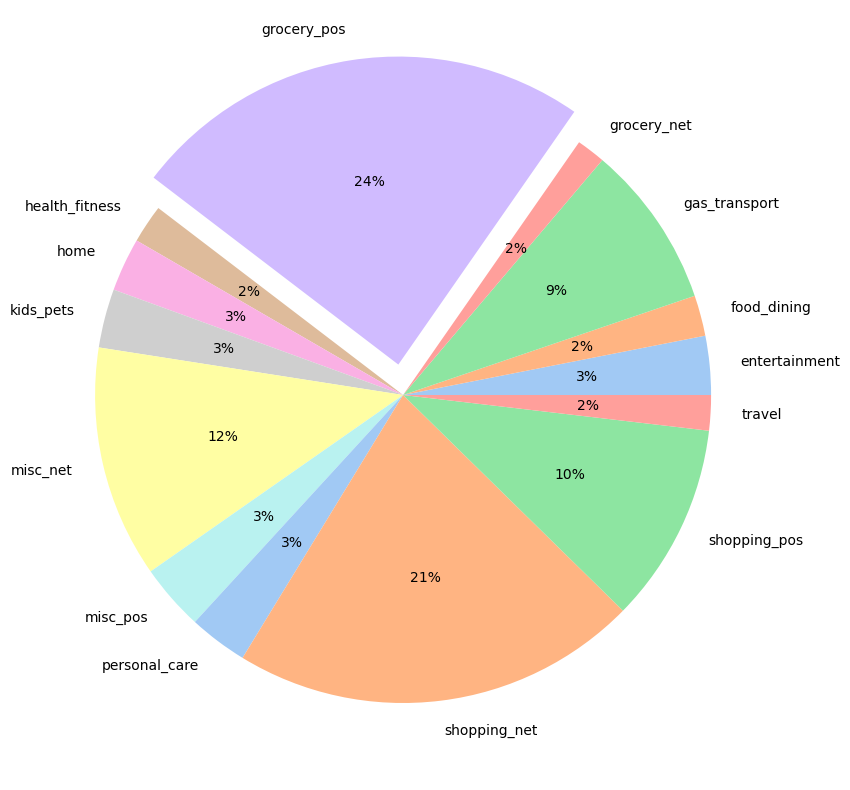

In [64]:
#fraudulent transactions by purchases

Frud_trac_pur = DE_data[DE_data['is_fraud'] == 1].groupby('category').count() #group by category

#printing fraud transactions by category
print(Frud_trac_pur.pivot_table(values='is_fraud', index='category'))

# Pie chart
_ = plt.figure(figsize=(15,10))
cat_len = len(Frud_trac_pur.index)
colors = sns.color_palette('pastel', n_colors=cat_len)
labels = Frud_trac_pur.index
explode = [0] * cat_len
max_fraud_category = Frud_trac_pur['is_fraud'].idxmax()
explode[labels.tolist().index(max_fraud_category)] = 0.1
_ = plt.pie(Frud_trac_pur['is_fraud'], labels=labels, 
            colors=colors, autopct='%.0f%%', 
            explode=explode)
plt.show()

In [65]:
#Fraud Grocery_pos transactions reported by user age groups

# Calculate the number of grocery_pos category fraud transactions grouped by User Age
grocery_pos_fraud_by_age = DE_data[(DE_data['category'] == 'grocery_pos') & 
        (DE_data['is_fraud'] == 1)].groupby('User Age').size().reset_index(name='Count')

# Create age groups
bins = [20, 30, 40, 50, 60, 70, 80, 90, 100]

# Group the counts by age groups
grocery_pos_fraud_by_age['Age Group'] = pd.cut(grocery_pos_fraud_by_age['User Age'], 
       bins=bins, right=False, 
       labels=['20-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'])

# Sum the counts by age groups
fraud_transactions_by_age_group = grocery_pos_fraud_by_age.groupby('Age Group')['Count'].sum()

fraud_transactions_by_age_group



Age Group
20-30      43
31-40      61
41-50      50
51-60     103
61-70      81
71-80      27
81-90      52
91-100     16
Name: Count, dtype: int64

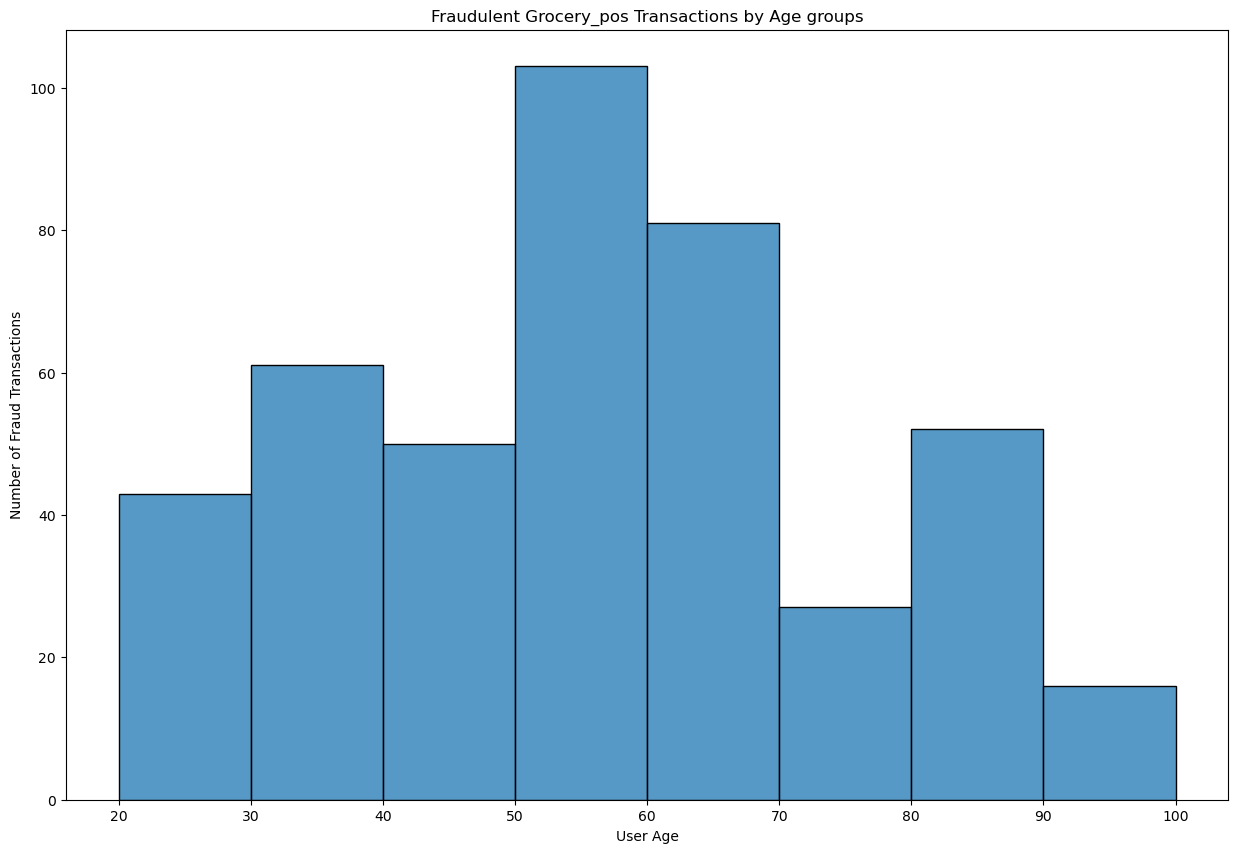

In [66]:
#histogram
bins = [20, 30, 40, 50, 60, 70, 80, 90, 100]  

_ = plt.figure(figsize=(15,10))
_ = sns.histplot(data=grocery_pos_fraud_by_age, x='User Age', 
                 weights='Count', bins=bins)  
_ = plt.xlabel("User Age")
_ = plt.ylabel('Number of Fraud Transactions')
_ = plt.title('Fraudulent Grocery_pos Transactions by Age groups')

plt.show()

In [67]:
#Grocery_POS fraud transactions by merchant

Merchant_Grcry_fraud = DE_data[(DE_data['is_fraud']==1) & 
                               (DE_data['category']=='grocery_pos')].groupby('merchant').count().sort_values(by='is_fraud',
                                                                                                             ascending=False)

print(Merchant_Grcry_fraud.pivot_table(index='merchant', 
                                       values='is_fraud').sort_values('is_fraud',
                                                                      ascending=False).head(10))

Most_fraud_trnsctns_vendor = Merchant_Grcry_fraud.index[0]

Number_fraud_trnsctns_vendor = Merchant_Grcry_fraud.loc[Merchant_Grcry_fraud.index==Most_fraud_trnsctns_vendor, 
                                                        'is_fraud'].sum()

Total_trnscts_amt_grocery_pos = Merchant_Grcry_fraud['is_fraud'].sum()

Most_fraud_trnsctns_vendor_prop = (Number_fraud_trnsctns_vendor/Total_trnscts_amt_grocery_pos)*100

print(f'Total fraud Grocery_pos transactions are {Total_trnscts_amt_grocery_pos} and most fraud transaction registered vendor is {Most_fraud_trnsctns_vendor} having {Number_fraud_trnsctns_vendor} transactions which is {round(Most_fraud_trnsctns_vendor_prop,2)}%.')

                             is_fraud
merchant                             
Kiehn-Emmerich                     19
Kunze Inc                          16
Strosin-Cruickshank                14
Kilback LLC                        14
Schultz, Simonis and Little        13
Murray-Smitham                     13
McDermott-Weimann                  13
Kutch and Sons                     13
Hudson-Ratke                       12
Lockman Lt                         12
Total fraud Grocery_pos transactions are 433 and most fraud transaction registered vendor is Kiehn-Emmerich having 19 transactions which is 4.39%.


                is_fraud
category                
entertainment          7
food_dining           13
gas_transport         34
grocery_net            1
grocery_pos           83
health_fitness        11
home                  20
kids_pets             11
misc_net              37
misc_pos              19
personal_care         11
shopping_net          77
shopping_pos          38
travel                 5


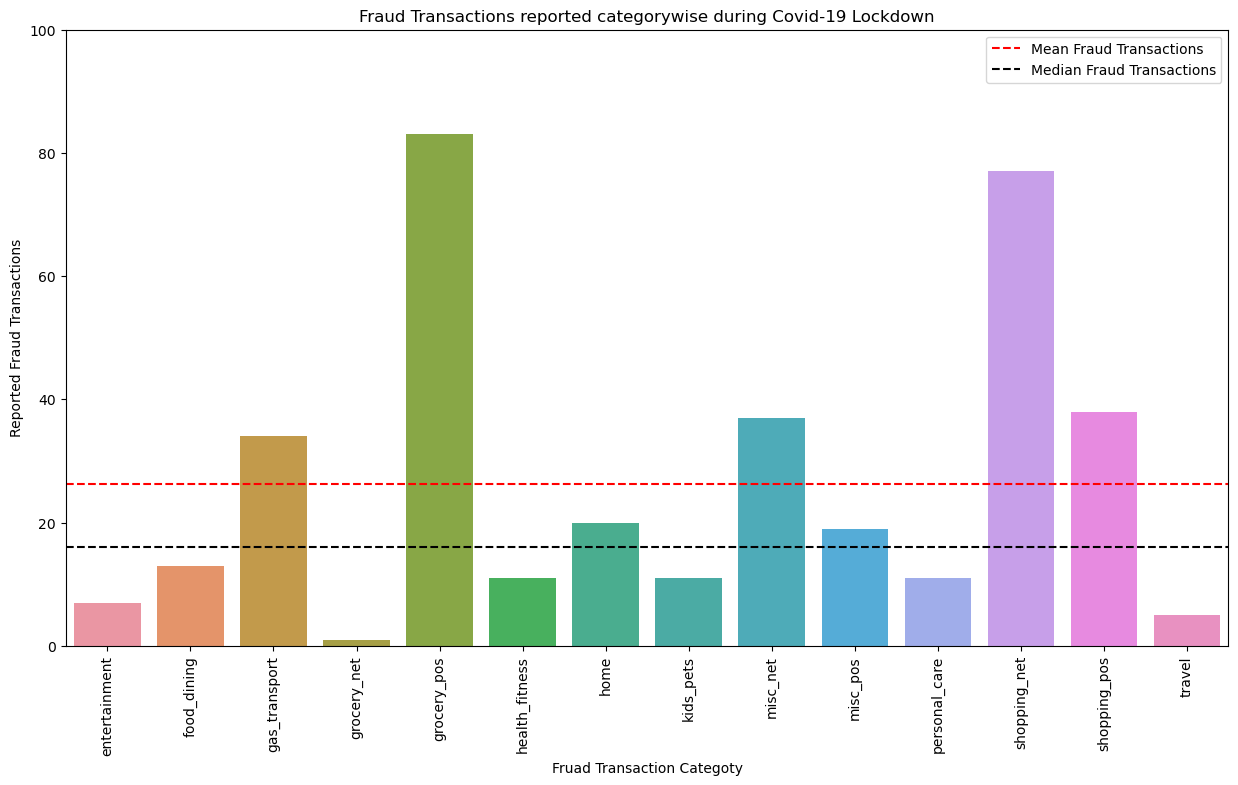

In [68]:
#This dataset contains year 2019 to 2020 credit card fraud transactions. March 2020 to July 2020 was COVID-19 pandemic and lockdown. Let's take a fraud transactions between this period.

#Slicing dataset from March 2020 to July 2020

Pandemic_trnscts = DE_data[(DE_data['trans_date_trans_time']>'2020-02-28 23:59:59') & 
                           (DE_data['trans_date_trans_time']<'2020-07-31 23:59:59') ]

#storing fraud transaction
Pandemic_frd_trnsctns = Pandemic_trnscts[Pandemic_trnscts['is_fraud']==1].groupby('category').count()

print(Pandemic_frd_trnsctns[['is_fraud']]) 

#even during pandemic grocery_pos frauds were highest followed by internet shopping

_ = plt.figure(figsize=(15,8))
_ = sns.barplot(data=Pandemic_frd_trnsctns.reset_index(), x='category', 
                y='is_fraud')
_ = plt.xlabel('Fruad Transaction Categoty')
_ = plt.ylabel('Reported Fraud Transactions')
_ = plt.title('Fraud Transactions reported categorywise during Covid-19 Lockdown')
_ = plt.axhline(Pandemic_frd_trnsctns['is_fraud'].mean(), color='red', 
                linestyle='--', 
                label='Mean Fraud Transactions')
_ = plt.axhline(Pandemic_frd_trnsctns['is_fraud'].median(), 
                color='black', linestyle='--', 
                label='Median Fraud Transactions')
_ = plt.legend()
_ = plt.ylim(0,100)
plt.xticks(rotation=90)
plt.show()

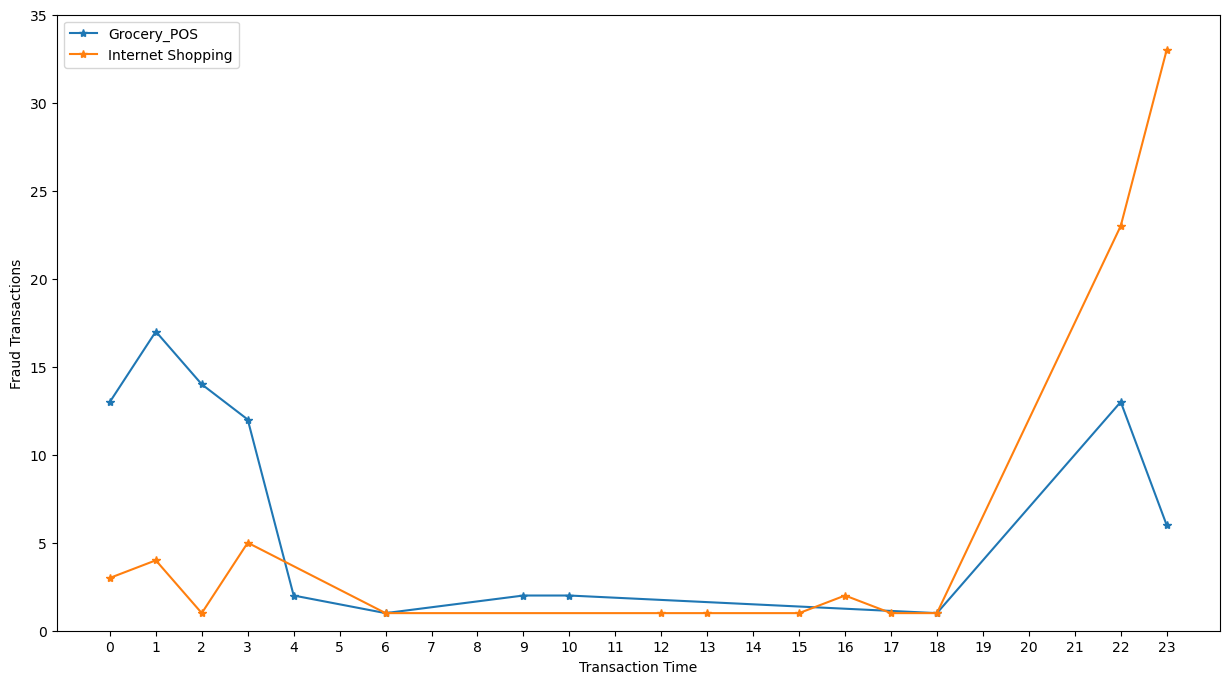

In [69]:
#What is the time of the internet shopping and grocery pos transactions during COVID-19 lockdown

#storing fraud grocey transactions
fraud_pandemic_grocery_trnscts = Pandemic_trnscts[(Pandemic_trnscts['is_fraud']==1) & 
                 (DE_data['category']=='grocery_pos')].groupby('Time').count()

#resetting index
fraud_pandemic_grocery_trnscts.reset_index(inplace=True)

#Changing column names
fraud_pandemic_grocery_trnscts = fraud_pandemic_grocery_trnscts[['Time','category']] 

#converting to panda DataFrame and resetting column name to appropriate category
fraud_pandemic_grocery_trnscts = pd.DataFrame(fraud_pandemic_grocery_trnscts)
fraud_pandemic_grocery_trnscts.rename({'Time': 'Transaction Time', 'category': 'Grocery_POS'}, 
                                      axis=1, inplace=True)

#storing fraud online shopping transactions
fraud_pandemic_internet_shopping_trnscts = Pandemic_trnscts[(Pandemic_trnscts['is_fraud']==1) & 
                 (DE_data['category']=='shopping_net')].groupby('Time').count()

#resetting index
fraud_pandemic_internet_shopping_trnscts.reset_index(inplace=True)

#Column rename to category and Time
fraud_pandemic_internet_shopping_trnscts = fraud_pandemic_internet_shopping_trnscts[['Time','category']]

#converting to panda DataFrame and resetting column name to appropriate category
fraud_pandemic_internet_shopping_trnscts = pd.DataFrame(fraud_pandemic_internet_shopping_trnscts)

fraud_pandemic_internet_shopping_trnscts.rename({'Time':'Transaction Time','category':'Internet Shopping'}, 
                                                axis=1, inplace=True)

#plotting grocery and online shopping line graph

#setting axis and plot size
fig, ax = plt.subplots(figsize=(15, 8))
fraud_pandemic_grocery_trnscts.plot(x='Transaction Time', y='Grocery_POS', ax=ax, label='Grocery_POS', marker='*')
                                    

# Plot the second dataset on the same axis
fraud_pandemic_internet_shopping_trnscts.plot(x='Transaction Time', y='Internet Shopping', ax=ax, label='Internet Shopping', marker='*')

# Set x and y limits
ax.set_ylim(0, 35)
ax.set_xticks(range(0, 24, 1))

# Set labels and legend
ax.set_xlabel('Transaction Time')
ax.set_ylabel('Fraud Transactions')
ax.legend()

# Show the plot
plt.show()

In [70]:


#Age group 50 to 70 is most vulnerable to fraud activities. Can we assume this is true?

#Hypothesis testing
#(H0): The proportion of fraud transactions in the age group 50 to 70 is equal to 
#the proportion of fraud transactions in other age groups.

#(Ha): The proportion of fraud transactions in the age group 50 to 70 is 
#different from the proportion of fraud transactions in other age groups. (claim)

#Data extraction

# Count the number of fraud transactions in the age group
Fraud_50_70_trnscts = DE_data[(DE_data['is_fraud']==1) & 
                              ((DE_data['User Age']>49) & 
                               (DE_data['User Age']<71))]

#Count the total transactions in the age group
Total_50_70_trnscts = DE_data[(DE_data['User Age']>49) & 
                              (DE_data['User Age']<71)]

#printing collected data
print(f'The total 50 to 70 age group transactions are {len(Total_50_70_trnscts)} and fraud transactions are {len(Fraud_50_70_trnscts)}.')

#calculating proportions of fraud transactions in the age group 50 to 70
Fraud_50_70_prop = len(Fraud_50_70_trnscts)/len(Total_50_70_trnscts)

#Calculating the fraud transactions in all other age groups combined.
Total_fraud_other_age_grp_trnscts = DE_data[(DE_data['is_fraud']==1) & 
                                            ((DE_data['User Age'] < 50) | 
                                             (DE_data['User Age'] > 70))]

#Calculating the total transactions in all other age groups combined
Total_trnscts_other_age = DE_data[(DE_data['User Age'] < 50) | 
                                  (DE_data['User Age'] > 70)]

#printing collected data
print(f'The total other age group transactions are {len(Total_trnscts_other_age)} and fraud transactions are {len(Total_fraud_other_age_grp_trnscts)}')

#calculating the proportion of fraud transactions in the other age groups
Fraud_other_age_prop = len(Total_fraud_other_age_grp_trnscts)/len(Total_trnscts_other_age)

#hypothesis testing
z_stat, p_value = proportions_ztest([len(Fraud_50_70_trnscts), 
                   len(Total_fraud_other_age_grp_trnscts)], 
                  [len(Total_50_70_trnscts), 
                   len(Total_trnscts_other_age)], 
                  alternative='two-sided')

#p-value comparison
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Age group 50 to 70 is vulnerable to fraud transactions.")
else:
    print("Fail to reject the null hypothesis: No significant evidence of vulnerability.")

The total 50 to 70 age group transactions are 119400 and fraud transactions are 724.
The total other age group transactions are 220207 and fraud transactions are 1058
Reject the null hypothesis: Age group 50 to 70 is vulnerable to fraud transactions.




<Center> 
  
  <B> <Font size = 6> Conclusion: <BR> </Font>
     <BR> Credit Card Frauds Dataset Analysis<BR>
  </B>

</Center>
  
<P>
    The credit card fraud dataset contains 339,607 observations and 15 variables. After ETL, I deleted some variables that were not useful for the analysis, such as latitude, longitude, vendor latitude, and vendor longitude. I also converted the <I>transaction_data_transaction_time</I> column into four new columns: Date, Month, Year, and Time. The DOB variable is converted into a date and time format to calculate user age. <BR>
<B>Limitations:</B> The main limitations of this dataset are that it covers only a two-year period and is limited to the USA region. The results of this analysis may not be the same if it were performed on a larger dataset with more recent data. Additionally, this study is confined to the United States region. <BR>

This dataset will help us answer the following business questions and test the stated hypothesis. These business questions are crucial as they assist businesses in identifying and mitigating fraud.<BR>

<P>
<B> 1:</B> What are the top 10 maximum amount transactions and their respective transaction categories?<BR>
<B> 2:</B> How many fraud transactions are reported per state?<BR>
<B> 3:</B> What is the peak time for fraudulent transactions?<BR>
<B> 4:</B> How many fraudulent transactions are per age group?<BR>
<B> 5:</B> How many fraudulent transactions are per category?<BR>
<B> 6:</B> How many fraudulent transactions are in the highest category by age group?<BR>
<B> 7:</B> How many fraudulent transactions are reported during the COVID-19 lockdown period?<BR>
<B> 8:</B> What is the peak time for fraudulent transactions during the COVID-19 lockdown period?<BR>
<B> Hypothesis:</B> Users between the age group of 50 to 70 are the most vulnerable to fraud attacks. <BR>
<P>
<B><Font Size=5>Analysis:</Font></B><BR>
Based on these questions, businesses can identify which categories reported the most fraud transactions. The analysis of the dataset revealed the following trends:<BR>
<P>
<B>1.</B> Point of Sale (POS), one of the easiest options to steal users' information.<BR>
<B>2.</B> Between January 01, 2019, and December 31, 2020, there were a total of <B>1782</B> fraud transactions amounting to $\$$923,192.65, which constitutes <B>3.9$\%$</B> of the total value of approximately <B>$\$$23.96 million</B>. <BR>
<B>3.</B> Shopping POS has the highest $\$$1371 fraud transaction amount, while Grocery_POS and Internet Shopping are the most fraudulent transaction activities.<BR>
<B>4.</B> The merchant <B><I>"Kiehn-Emmerich"</I></B> has a total of 19 Grocery_POS fraud transactions registered, accounting for 4.39$\%$ of total fraud Grocery_POS transactions.<BR>
<B>5.</B> California has reported 402 fraud transactions, accounting for almost 22% of total fraud transactions.<BR>
<B>6.</B> The peak time for internet shopping fraud was between 10 PM and 3 AM. This is when authorized users are less likely to be able to stop the fraud activity.<BR>
<P>This aligns with recent fraudulent trends of stealing users' information by installing skimmers and shimmers on POS machines in retail stores and restaurants, unguarded ATM machines, ATM machine doors, and gas stations (Forbes advisor staff, 2023; Cobb, 2022). <BR>
<P>
The age group 50-70 is the most vulnerable to fraudulent activities. The Federal Trade Commission (n.d., as cited in Campisi, 2022) indicated that the 50-69 years old age group had 23$\%$ whereas the age group 30-49 had as high as 54$\%$ credit card frauds. However, this trend is not as visible in this dataset. Despite the analytical evidence about which age group is prone to be a victim of identity theft or some other sort of financial fraud, it is essential for the Government, policy makers, and financial institutes to promote how to avoid these instances and what measures can be taken to safeguard oneself. <BR>
<P>
In summary, the dataset suggests that skimmers and shimmers are used in unguarded ATM machines, gas stations, and retail stores. Users need to be vigilant about POS machines and safeguard themselves from falling for identity theft. As this dataset supports the claim that users between the age group of 50-70 are vulnerable to fraudulent credit card transactions, financial institutes must take necessary steps, such as educating people on possible frauds and scams, promoting 2-factor authentications, and requesting password changes every month or two. Elderly adults also need to be cautious when seeking help, whether it's withdrawing money from the ATM or sharing personal information aloud in public spaces.
    


 
  <B> <Font size = 5> References: <BR> </Font></B>
Campisi, N. (2022). <I>It’s Not Just Your Parents’ Problem: Younger People Report Identity Theft More Than Any Other Generation</I>. https://www.forbes.com/advisor/personal-finance/identity-theft-by-age-group/<BR>
Cobb, D. (2022). <I>U.S. Card Skimming Fraud Grows 700+ in First Half of 2022</I>. https://www.fico.com/blogs/us-card-skimming-fraud-grows-700-first-half-2022<BR>
Federal Trade Commission. (n.d.). <I>Imposter scams targeting veterans and servicemembers</I>. https://consumer.ftc.gov/credit-loans-debt<BR>
Forbes advisor staff. (2023). <I>How To Spot A Credit Card Skimmer</I>. https://www.forbes.com/advisor/credit-cards/how-to-spot-a-credit-card-skimmer
